# CMBD with Bootstrapping

In [ ]:
import sys
module_path_lib = r"../lib"
sys.oath.append(module_path_lib)

import CMBD.ConwayMaxwellBinomial as cmb
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path

In [3]:
from tqdm import tqdm

def exact_pmf_cdf(dist, xs):
    """Return PMF and CDF arrays for the given COM-B distribution over xs."""
    pmf = np.array([dist.pmf(k) for k in xs], dtype=float)
    pmf = pmf / pmf.sum()                     # guard against tiny drift
    cdf = np.cumsum(pmf)
    return pmf, cdf

approaches = [
    # {
    #     'name': 'Multi-feature - 2 nights',
    #     'datasets': [
    #         {'Dx': 'control', 'method': 'multi', 'dataset': 'NSRR', 'nights': 2, 'outcomes': [0]*4601 + [1]*(122) + [2]*9},
    #         {'Dx': 'NT1', 'method': 'multi', 'dataset': 'comb', 'nights': 2, 'outcomes': [0]*9 + [1]*9 + [2]*12} # + [3]*4},
    #     ]
    # }, 
    {
        'name': 'Multi-feature - 3 nights',
        'datasets': [
            # {'Dx': 'control', 'method': 'multi', 'dataset': 'NSRR', 'nights': 2, 'outcomes': [0]*4601 + [1]*(122) + [2]*9},
            {'Dx': 'control', 'method': 'soremps', 'dataset': 'NSRR', 'nights': 2, 'outcomes': [0]*4580 + [1]*(148) + [2]*4},
            #{'Dx': 'control', 'method': 'multi', 'dataset': 'NSRR', 'nights': 2, 'outcomes': [0]*4580 + [1]*(148) + [2]*4},
            {'Dx': 'NT1', 'method': 'multi', 'dataset': 'comb', 'nights': 3, 'outcomes': [0]*6 + [1]*6 + [2]*2 + [3]*4},
        ]
    }, 
    {
        'name': 'SOREMP',
        'datasets': [
            {'Dx': 'control', 'method': 'soremps', 'dataset': 'NSRR', 'nights': 2, 'outcomes': [0]*4580 + [1]*(148) + [2]*4},
            {'Dx': 'NT1', 'method': 'soremps', 'dataset': 'TAK-all', 'nights': 2, 'outcomes': [0]*16 + [1]*(3+4) + [2]*5},
        ]
    }, 

]

# parameters
n_bootstraps = 10_000
n_samples = 100
recordings = 14
n_simulations = n_bootstraps * n_samples
df_outer = pd.DataFrame()

for approach in approaches:
    for dataset in approach['datasets']:
        df_inner = pd.DataFrame()
        
        # extract parameters
        x = np.asarray(dataset.get('outcomes'))
        m = dataset.get('nights')

        # bootstrapping
        for recording in tqdm(range(1, recordings+1), desc=f"{approach['name']}. Dx={dataset['Dx']}"):
            samples, p_est, nu_est = [], [], []
            for _ in range(n_bootstraps):
                
                # sample
                x_resampled = np.random.choice(x, size=len(x), replace=True) # Resample with replacement

                # estimate parameters and distribution
                p_est_, nu_est_ = cmb.estimateParams(m, x_resampled) # Estimate parameters from resampled data
                cmbd_dist = cmb.ConwayMaxwellBinomial(p_est_,  nu_est_,  recording) # Build COM-B distribution
                # pmf, cdf = exact_pmf_cdf(cmbd_dist, x) # Compute PMF/CDF for this distribution
                
                # store
                p_est += [p_est_] * n_samples
                nu_est += [nu_est_] * n_samples
                samples += cmbd_dist.rvs(size=n_samples).tolist() # Sample from distribution
            
            # Append estimated parameters and distribution. When done this way, df will automatically expand rows due to broadcasting.
            df_inner = pd.concat(
                [
                    df_inner,
                    pd.DataFrame.from_dict({
                        'approach': approach['name'],
                        'Dx': dataset.get('Dx'),
                        'method': dataset.get('method'),
                        'dataset': dataset.get('dataset'),
                        'nights': m,
                        'n_recs': recording, 
                        'n_pos_recs': samples,
                        'p_bootstrapped': p_est,
                        'nu_bootstrapped': nu_est
                    })
                ], ignore_index=True
            )
        df_outer = pd.concat([df_outer, df_inner], ignore_index=True)
        
print(df_outer['approach'].unique())
print(df_outer.shape)
print(df_outer.info())
df_outer.tail()

SOREMP. Dx=NT1: 100%|██████████| 14/14 [02:54<00:00, 12.44s/it]


['Multi-feature - 3 nights' 'SOREMP']
(56000000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000000 entries, 0 to 55999999
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   approach         object 
 1   Dx               object 
 2   method           object 
 3   dataset          object 
 4   nights           int64  
 5   n_recs           int64  
 6   n_pos_recs       int64  
 7   p_bootstrapped   float64
 8   nu_bootstrapped  float64
dtypes: float64(2), int64(3), object(4)
memory usage: 3.8+ GB
None


,approach,Dx,method,dataset,nights,n_recs,n_pos_recs,p_bootstrapped,nu_bootstrapped
55999995,SOREMP,NT1,soremps,TAK-all,2,14,2,0.340542,0.21648
55999996,SOREMP,NT1,soremps,TAK-all,2,14,0,0.340542,0.21648
55999997,SOREMP,NT1,soremps,TAK-all,2,14,1,0.340542,0.21648
55999998,SOREMP,NT1,soremps,TAK-all,2,14,4,0.340542,0.21648
55999999,SOREMP,NT1,soremps,TAK-all,2,14,9,0.340542,0.21648


In [4]:
df_outer['n_recs'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

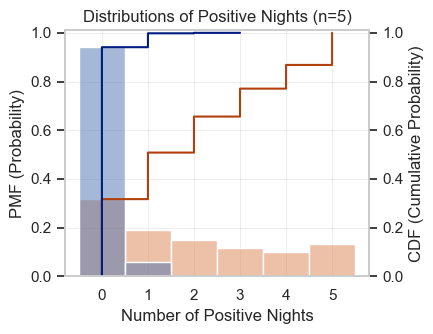

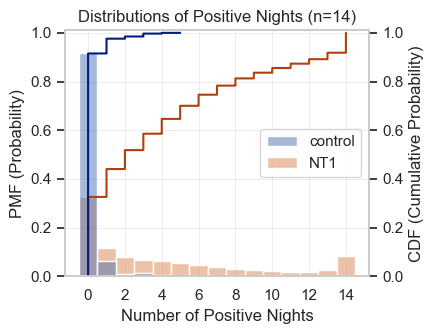

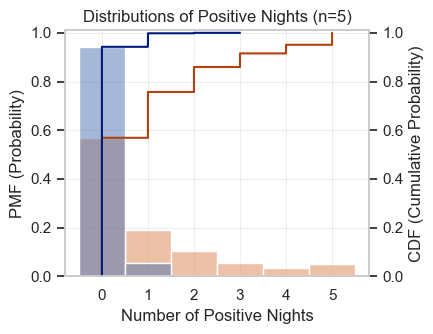

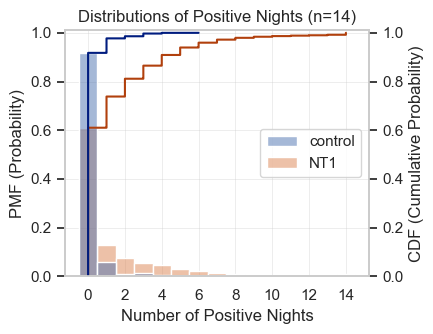

In [ ]:
#names = [a['name'] for a in approaches]
#print(names)

sns.set(style='whitegrid')

# parameters
n_recs_all = [5, 14]

#for approach in ['Multi-feature - 2 nights', 'Multi-feature - 3 nights', 'SOREMP']:
for approach in ['Multi-feature - 3 nights', 'SOREMP']:
    for i, n_recs in enumerate(n_recs_all):
    
        # filter data
        df_ = df_outer.query("(approach == @approach) & (n_recs == @n_recs)").copy()
        
        # figure
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5))

        sns.histplot(
            data=df_,
            x='n_pos_recs',
            hue='Dx',
            hue_order=['control', 'NT1'],
            ax=ax,
            stat='probability',  # normalize
            common_norm=False,   # don't normalize across all hue groups
            multiple='layer',    # side-by-side bars like countplot
            shrink=1,          # optional: shrink bar width for spacing
            discrete=True        # ensure bars don't overlap if feature is discrete
        )

        ax.set_xlabel("Number of Positive Nights")
    
        ax.set_ylabel("PMF (Probability)")
        ax.set_title(f"Distributions of Positive Nights (n={n_recs})")
        ax.set_ylim(0, 1.01)
        ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, alpha=0.5)
        # xticks
        max_ticks = 8
        xticks = np.linspace(0, n_recs, num=min(max_ticks, n_recs+1), dtype=int)
        ax.set_xticks(xticks)

        ax2 = ax.twinx()
        sns.ecdfplot(
            data=df_,
            x='n_pos_recs',
            hue='Dx',
            hue_order=['control', 'NT1'],
            ax=ax2,
            palette='dark'
        )
        
        ax2.set_ylabel("CDF (Cumulative Probability)")
        ax2.set_ylim(0, 1.01)
        ax2.grid(False)
        
        # Legends: keep only one combined legend on the right-most panel
        leg1 = ax.get_legend()
        if leg1:
            if i == len(n_recs_all) - 1:
                leg1.set_title(None)
                leg1.set_loc("center right")
            else:
                leg1.remove()

        leg2 = ax2.get_legend()
        if leg2:
            leg2.remove()

        plt.tight_layout() 
        

In [6]:
def compute_confusion_matrix(y_true, y_pred, prevalence=1/1024):
    tp = round(((y_pred == 1) & (y_true == 1)).sum() * prevalence)
    tn = round(((y_pred == 0) & (y_true == 0)).sum() * (1 - prevalence))
    fp = round(((y_pred == 1) & (y_true == 0)).sum() * (1 - prevalence))
    fn = round(((y_pred == 0) & (y_true == 1)).sum() * prevalence)
    
    return tp, tn, fp, fn

def compute_metrics(y_true, y_pred, prevalence):

    tp, tn, fp, fn = compute_confusion_matrix(y_true=y_true, y_pred=y_pred, prevalence=prevalence)
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    fp_tp_ratio = fp / tp if tp > 0 else np.inf
    f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else np.nan
    
    return {'Sensitivity': sensitivity, 'Specificity': specificity, 'PPV': ppv, 'FP:TP': fp_tp_ratio, 'F1 score': f1}



In [7]:
# parameters
prevalence=1/2048
thresholds = 5 #  [1, 2, 3, 4, 5]

metrics = []
#for approach in ['Multi-feature - 2 nights', 'Multi-feature - 3 nights', 'SOREMP']:
for approach in ['Multi-feature - 3 nights', 'SOREMP']:
    for n_rec in range(1, recordings+1):
        # filter data
        df_ = df_outer.query("(approach == @approach) & (n_recs == @n_rec)").copy()
        y = df_['Dx'].map({'control': 0, 'NT1': 1}).values
        
        for thresh in range(1, min(n_rec+1, 1+thresholds)):
            
            # apply threshold
            p_bin = (df_['n_pos_recs'].values >= thresh).astype(int)
            
            # compute metrics
            metrics.append({
                'approach': approach,
                'Recordings (n)': n_rec,
                'Min. required positive (n)': thresh,
                **compute_metrics(y_true=y, y_pred=p_bin, prevalence=prevalence)
            })

df_metrics = pd.DataFrame(metrics)
df_metrics.head(28)


,approach,Recordings (n),Min. required positive (n),Sensitivity,Specificity,PPV,FP:TP,F1 score
0,Multi-feature - 3 nights,1,1,0.441718,0.972572,0.007817,126.921296,0.015363
1,Multi-feature - 3 nights,2,1,0.575820,0.967734,0.008638,114.768683,0.017021
2,Multi-feature - 3 nights,2,2,0.269939,0.999180,0.138655,6.212121,0.183206
3,Multi-feature - 3 nights,3,1,0.639344,0.959378,0.007626,130.134615,0.015072
4,Multi-feature - 3 nights,3,2,0.388548,0.999077,0.170710,4.857895,0.237203
5,Multi-feature - 3 nights,3,3,0.194672,0.999973,0.778689,0.284211,0.311475
6,Multi-feature - 3 nights,4,1,0.670082,0.948595,0.006324,157.125382,0.012530
7,Multi-feature - 3 nights,4,2,0.453988,0.998787,0.154812,5.459459,0.230889
8,Multi-feature - 3 nights,4,3,0.288934,0.999979,0.870370,0.148936,0.433846
9,Multi-feature - 3 nights,4,4,0.155738,0.999999,0.987013,0.013158,0.269027


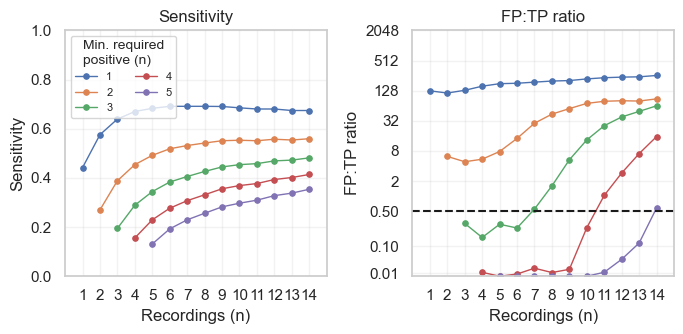

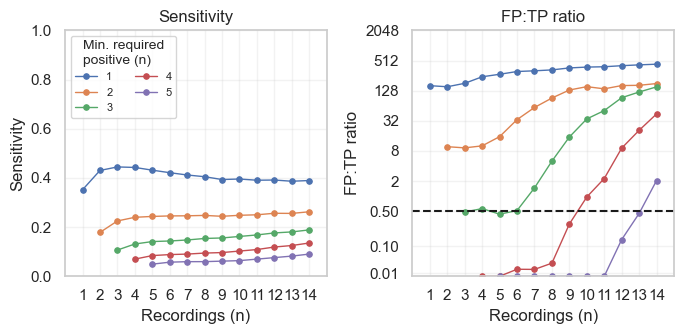

In [ ]:
#for approach in ['Multi-feature - 2 nights', 'Multi-feature - 3 nights', 'SOREMP']:
for approach in ['Multi-feature - 3 nights', 'SOREMP']:

    df_ = df_metrics.query("approach == @approach").copy()

    # Create plots
    fig, axes = plt.subplots(ncols=2, figsize=(7, 3.5))

    # Sensitivity plot
    sns.pointplot(data=df_, hue='Min. required positive (n)', y='Sensitivity', x='Recordings (n)', palette='deep', ax=axes[0], markers='o', ms=4, lw=1)
    axes[0].set_title('Sensitivity')
    axes[0].set_ylabel('Sensitivity')
    axes[0].grid(True, alpha=0.25)
    axes[0].set_ylim([0, 1])
    axes[0].set_xlim([-1, recordings])
    axes[0].legend().remove()
    axes[0].legend(title='Min. required\npositive (n)', loc='upper left', ncols=2, fontsize=8, title_fontsize=10)

    # FP:TP Ratio plot
    sns.pointplot(data=df_, hue='Min. required positive (n)', y='FP:TP', x='Recordings (n)', palette='deep', ax=axes[1], markers='o', ms=4, lw=1)
    axes[1].set_title('FP:TP ratio')
    axes[1].set_ylabel('FP:TP ratio')
    axes[1].grid(True, alpha=0.25)
    # axes[1].axhline(y=max_FPTP, color='black', linestyle='--', label='Max FP:TP')

    ticks = [0.01, 0.1, 0.5, 2, 8, 32,  128,  512, 2048]
    axes[1].set_yscale('symlog', base=2, linthresh=0.1)
    axes[1].set_ylim([0, 2e3])
    axes[1].set_xlim([-1, recordings])
    axes[1].set_yticks(ticks)
    axes[1].set_yticklabels([f'{tick:.2f}' if tick < 1 else f'{tick}' for tick in ticks])
    axes[1].legend().remove()
    axes[1].axhline(0.5, ls='--', color='k')
    

    # F1 score plot
    # sns.pointplot(data=df_, hue='Min. required positive (n)', y='F1 score', x='Recordings (n)', palette='deep', ax=axes[2], markers='o', ms=4, lw=1)
    # # axes[2].set_title(f'F1 score (FP:TP < {max_FPTP:.1f})')
    # axes[2].set_ylabel('F1 score')
    # axes[2].grid(True, alpha=0.25)
    # axes[2].set_ylim([0, 1])
    # axes[2].set_xlim([-1, recordings])
    # axes[2].legend().remove()
    # axes[2].legend(title='Min. required positive (n)', loc='upper left', ncols=2, fontsize=8)

    plt.tight_layout()


# plot CMBD parameters

Approach: Multi-feature - 3 nights, n_recs: 5, Dx: control, p_mean: 0.02747183367510894, p_std: 0.007796920350907636
Approach: Multi-feature - 3 nights, n_recs: 5, Dx: control, v_mean: 0.330591366429991, v_std: 0.9439882714204907
Approach: Multi-feature - 3 nights, n_recs: 5, Dx: NT1, p_mean: 0.43974705995289104, p_std: 0.0646866946859773
Approach: Multi-feature - 3 nights, n_recs: 5, Dx: NT1, v_mean: -0.11695081306924035, v_std: 0.5790898681879846
Approach: Multi-feature - 3 nights, n_recs: 14, Dx: control, p_mean: 0.027568006192778934, p_std: 0.00782218772411993
Approach: Multi-feature - 3 nights, n_recs: 14, Dx: control, v_mean: 0.3238065601158914, v_std: 0.9439309734852882
Approach: Multi-feature - 3 nights, n_recs: 14, Dx: NT1, p_mean: 0.4396236067485856, p_std: 0.06500363197421787
Approach: Multi-feature - 3 nights, n_recs: 14, Dx: NT1, v_mean: -0.10095448971500859, v_std: 0.6165529052263675
Approach: SOREMP, n_recs: 5, Dx: control, p_mean: 0.02756250432860465, p_std: 0.007751735

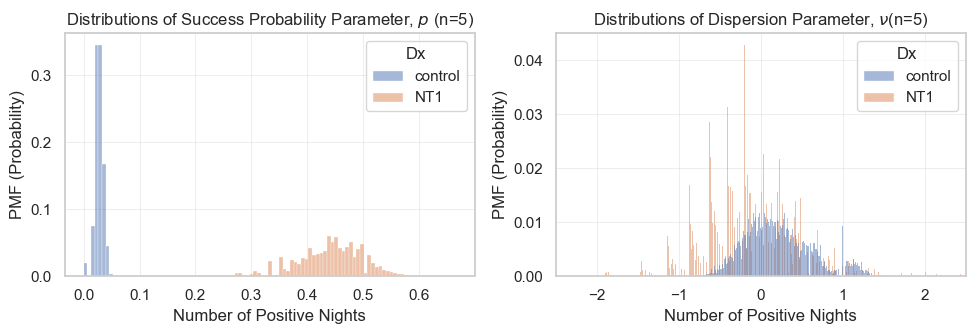

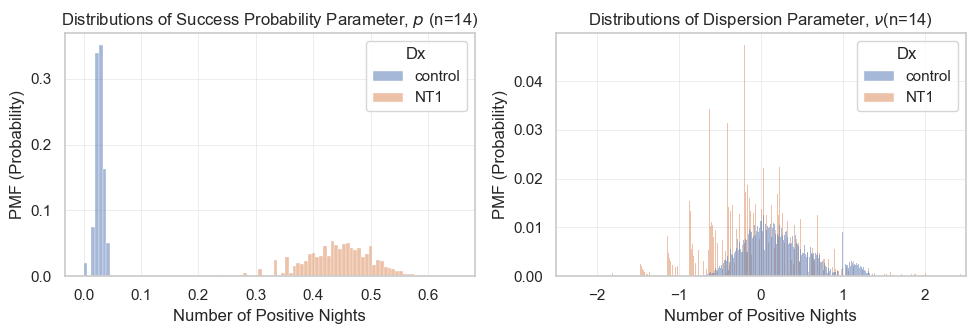

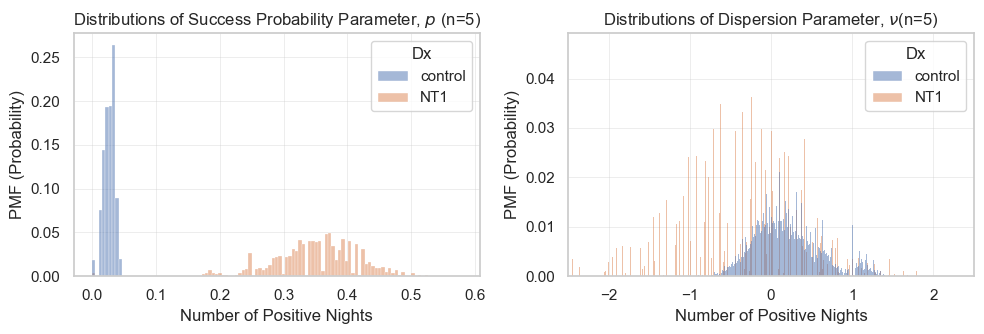

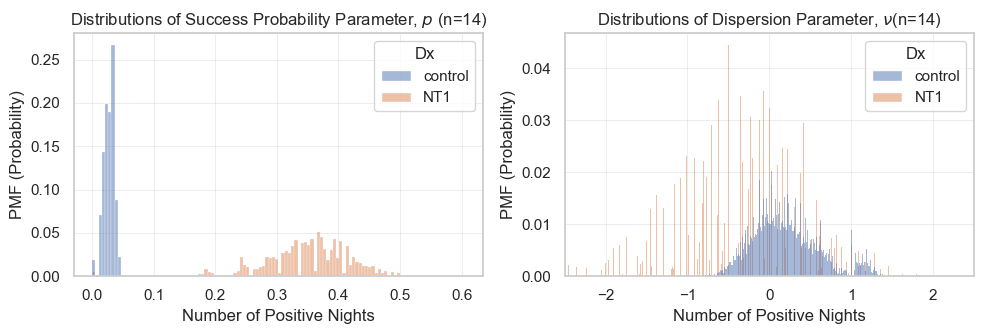

In [ ]:
#names = [a['name'] for a in approaches]
#print(names)

sns.set(style='whitegrid')

# parameters
n_recs_all = [5, 14]

for approach in ['Multi-feature - 3 nights', 'SOREMP']:
    for i, n_recs in enumerate(n_recs_all):
    
        # filter data
        df_ = df_outer.query("(approach == @approach) & (n_recs == @n_recs)").copy()
        for dx in ['control', 'NT1']:
            df__ = df_.query("Dx == @dx").copy()
            print(f"Approach: {approach}, n_recs: {n_recs}, Dx: {dx}, p_mean: {df__['p_bootstrapped'].mean()}, p_std: {df__['p_bootstrapped'].std()}")
            print(f"Approach: {approach}, n_recs: {n_recs}, Dx: {dx}, v_mean: {df__['nu_bootstrapped'].mean()}, v_std: {df__['nu_bootstrapped'].std()}")
        # figure
        fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

        # probability parameter
        sns.histplot(
            data=df_,
            x='p_bootstrapped',
            hue='Dx',
            hue_order=['control', 'NT1'],
            ax=axes[0],
            stat='probability',  # normalize
            common_norm=False,   # don't normalize across all hue groups
            multiple='layer',    # side-by-side bars like countplot
            shrink=1,          # optional: shrink bar width for spacing
            discrete=False,        # ensure bars don't overlap if feature is discrete
            #bins=10
        )
        axes[0].set_xlabel("Number of Positive Nights")
        axes[0].set_ylabel("PMF (Probability)")
        axes[0].set_title(rf"Distributions of Success Probability Parameter, $p$ (n={n_recs})")
        #axes[0].set_ylim(0, 1.01)
        #axes[0].set_xlim(df_['p_bootstrapped'].min(), df_['p_bootstrapped'].max())
        axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, alpha=0.5)
        # xticks
        #max_ticks = 8
        #xticks = np.linspace(0, n_recs, num=min(max_ticks, n_recs+1), dtype=int)
        #axes[0].set_xticks(xticks)
        
        # Dispersion parameter
        sns.histplot(
            data=df_,
            x='nu_bootstrapped',
            hue='Dx',
            hue_order=['control', 'NT1'],
            ax=axes[1],
            stat='probability',  # normalize
            common_norm=False,   # don't normalize across all hue groups
            multiple='layer',    # side-by-side bars like countplot
            shrink=1,          # optional: shrink bar width for spacing
            discrete=False,        # ensure bars don't overlap if feature is discrete
            #bins=10

        )
        axes[1].set_xlabel("Number of Positive Nights")
        axes[1].set_ylabel("PMF (Probability)")
        axes[1].set_title(rf"Distributions of Dispersion Parameter, $\nu$(n={n_recs})")
        #axes[1].set_ylim(0, 1.01)
        axes[1].set_xlim(-2.5, 2.5)
        axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=0.5, alpha=0.5)
        # xticks
        #max_ticks = 8
        #xticks = np.linspace(0, n_recs, num=min(max_ticks, n_recs+1), dtype=int)
        #axes[1].set_xticks(xticks)
        
        # Legends: keep only one combined legend on the right-most panel
        # leg1 = ax.get_legend()
        # if leg1:
        #     if i == len(n_recs_all) - 1:
        #         leg1.set_title(None)
        #         leg1.set_loc("center right")
        #     else:
        #         leg1.remove()

        plt.tight_layout() 
        